### Import Libraries

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import mlflow.pyfunc
import pickle
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score, r2_score

from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

### Set display option to show Max Row & Column

In [147]:
pd.set_option('display.max_rows', None)

pd.set_option('display.max_columns', None)

In [148]:
data = pd.read_csv(r'C:\Users\ASUS PC\Desktop\AMDARI INTERNSHIP\Med_Optix\Optix_repo\Model\cleaned_df.csv', parse_dates=['date'])

data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')

In [149]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21758 entries, 0 to 21757
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         21758 non-null  datetime64[ns]
 1   hospital_id                  21758 non-null  int64         
 2   ward_code                    21758 non-null  object        
 3   wait_per_triage              21758 non-null  float64       
 4   age                          21758 non-null  float64       
 5   bed_impact_score             5440 non-null   float64       
 6   arrival_source_ambulance     21758 non-null  int64         
 7   arrival_source_referral      21758 non-null  int64         
 8   arrival_source_self          21758 non-null  int64         
 9   arrival_source_transfer      21758 non-null  int64         
 10  outcome_death                21758 non-null  int64         
 11  outcome_discharged           21758 non-null  i

In [150]:
def quick_overview(df, df_name):
  print(f"{df_name} dataframe information")
  print("="*60)
  print(df.info())
  print("\n")
  print(f"{df_name} missing values information")
  print("="*60)
  print(df.isnull().sum())
  print("\n")
  print(f"{df_name} describtion information")
  print("="*60)
  print(df.describe())
  print(f'Structure of {df_name} dataset')
  print('='*60)
  print(f"Row:{df.shape[0]}, Columns:{df.shape[1]}")

In [151]:
quick_overview(cleaned_df,'cleaned_df')

cleaned_df dataframe information
<class 'pandas.core.frame.DataFrame'>
Index: 21758 entries, 0 to 21757
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         21758 non-null  datetime64[ns]
 1   hospital_id                  21758 non-null  int64         
 2   ward_code                    21758 non-null  object        
 3   wait_per_triage              21758 non-null  float64       
 4   age                          21758 non-null  float64       
 5   bed_impact_score             5440 non-null   float64       
 6   arrival_source_ambulance     21758 non-null  int64         
 7   arrival_source_referral      21758 non-null  int64         
 8   arrival_source_self          21758 non-null  int64         
 9   arrival_source_transfer      21758 non-null  int64         
 10  outcome_death                21758 non-null  int64         
 11  outcome_disch

In [152]:
cleaned_df.columns

Index(['date', 'hospital_id', 'ward_code', 'wait_per_triage', 'age',
       'bed_impact_score', 'arrival_source_ambulance',
       'arrival_source_referral', 'arrival_source_self',
       'arrival_source_transfer', 'outcome_death', 'outcome_discharged',
       'outcome_readmit_30d', 'outcome_transferred', 'sex_F', 'sex_M',
       'base_beds', 'effective_capacity', 'admissions', 'staffing_index',
       'discharge_rate_per_bed', 'occupancy_lag1', 'occupancy_lag7',
       'overflow_lag1', 'overflow_lag7', 'discharges_lag1', 'discharges_lag7',
       'admission_rate_per_bed_lag1', 'admission_rate_per_bed_lag7',
       'avg_wait_minutes_lag1', 'avg_wait_minutes_lag7', 'occupancy_rate_lag1',
       'occupancy_rate_lag7', 'month'],
      dtype='object')

### Split Data by Date (Train/Val/Test)

In [153]:
train_size = 0.8
test_size = 0.2

split_idx = int(len(data) * 0.8)
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]




In [154]:
mi_data = data.drop(columns=['hospital_id', 'ward_code', 'date'])
features = [col for col in mi_data.columns if col not in ['date', 'admissions']]

In [155]:
X = train[features]
y = train['admissions']

In [156]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17406 entries, 0 to 17408
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   wait_per_triage              17406 non-null  float64
 1   age                          17406 non-null  float64
 2   bed_impact_score             4350 non-null   float64
 3   arrival_source_ambulance     17406 non-null  int64  
 4   arrival_source_referral      17406 non-null  int64  
 5   arrival_source_self          17406 non-null  int64  
 6   arrival_source_transfer      17406 non-null  int64  
 7   outcome_death                17406 non-null  int64  
 8   outcome_discharged           17406 non-null  int64  
 9   outcome_readmit_30d          17406 non-null  int64  
 10  outcome_transferred          17406 non-null  int64  
 11  sex_F                        17406 non-null  int64  
 12  sex_M                        17406 non-null  int64  
 13  base_beds            

In [157]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17406 entries, 0 to 17408
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   wait_per_triage              17406 non-null  float64
 1   age                          17406 non-null  float64
 2   bed_impact_score             4350 non-null   float64
 3   arrival_source_ambulance     17406 non-null  int64  
 4   arrival_source_referral      17406 non-null  int64  
 5   arrival_source_self          17406 non-null  int64  
 6   arrival_source_transfer      17406 non-null  int64  
 7   outcome_death                17406 non-null  int64  
 8   outcome_discharged           17406 non-null  int64  
 9   outcome_readmit_30d          17406 non-null  int64  
 10  outcome_transferred          17406 non-null  int64  
 11  sex_F                        17406 non-null  int64  
 12  sex_M                        17406 non-null  int64  
 13  base_beds            

In [158]:
X.isnull().sum()

wait_per_triage                    0
age                                0
bed_impact_score               13056
arrival_source_ambulance           0
arrival_source_referral            0
arrival_source_self                0
arrival_source_transfer            0
outcome_death                      0
outcome_discharged                 0
outcome_readmit_30d                0
outcome_transferred                0
sex_F                              0
sex_M                              0
base_beds                          0
effective_capacity                 0
staffing_index                     0
discharge_rate_per_bed             0
occupancy_lag1                     0
occupancy_lag7                     0
overflow_lag1                      0
overflow_lag7                      0
discharges_lag1                    0
discharges_lag7                    0
admission_rate_per_bed_lag1        0
admission_rate_per_bed_lag7        0
avg_wait_minutes_lag1              0
avg_wait_minutes_lag7              0
o

<Figure size 1000x800 with 0 Axes>

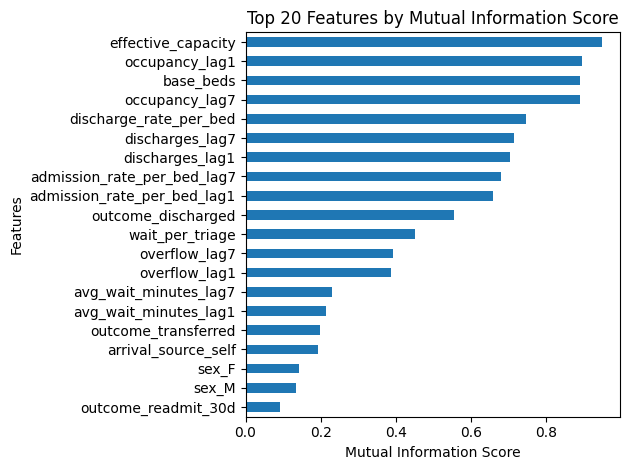

In [159]:


# 1. Remove datetime columns
X_clean = X.select_dtypes(exclude=['datetime64[ns]', 'datetime64']).copy()

# 2. Impute missing values
imputer = SimpleImputer(strategy='mean')
X_clean = pd.DataFrame(imputer.fit_transform(X_clean),
                       columns=X_clean.columns)

# 3. Compute MI scores
mi_scores = mutual_info_regression(X_clean, y, random_state=42)

# 4. Put into dataframe
mi_df = pd.DataFrame({
    'feature': X_clean.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

# 5. Plot
plt.figure(figsize=(10, 8))
mi_df.head(20).plot(x='feature', y='mi_score', kind='barh', legend=False)
plt.gca().invert_yaxis()
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.title('Top 20 Features by Mutual Information Score')
plt.tight_layout()
plt.show()


### Define Target and Feature

In [160]:
top_features = mi_df['feature'].head(20).tolist()
exog_features = top_features

data = cleaned_df.set_index('date')

weekly_target = data["admissions"].resample("W").sum()
weekly_exog = data[exog_features].resample("W").mean()

train_size = int(len(weekly_target) * 0.8)
train_y = weekly_target.iloc[:train_size]
test_y = weekly_target.iloc[train_size:]

train_exog = weekly_exog.iloc[:train_size]
test_exog = weekly_exog.iloc[train_size:]

Prediction error (MAE): 15.43
Prediction error (MSE): 326.94
Prediction error (RMSE): 18.08
Prediction error (MAPE): 103.76
Prediction error (R2): -0.03


2025/11/27 12:24:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/27 12:24:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


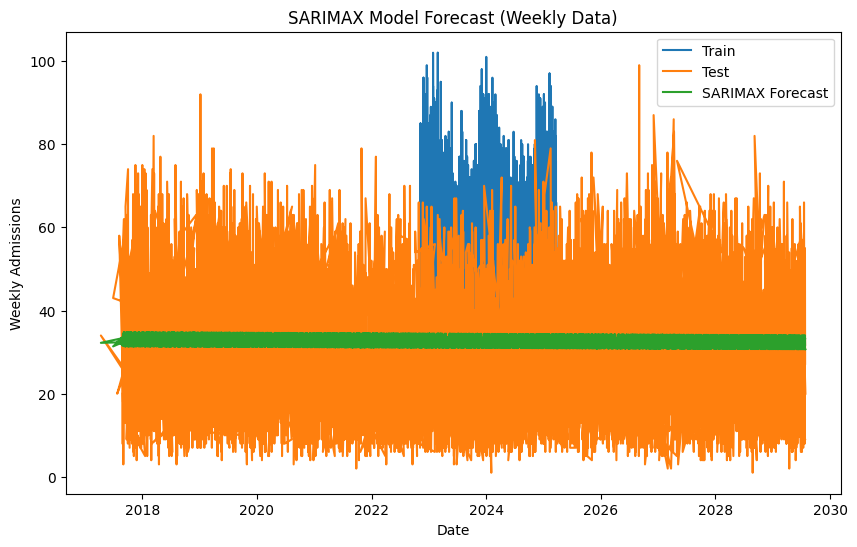

In [167]:
with mlflow.start_run(run_name="SARIMAX"):
    sarimax_model = SARIMAX(train['admissions'],
                            order=(1,0,1),
                            seasonal_order=(1,0,1,7),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
    
    sarimax_result = sarimax_model.fit(disp=False)
    pred = sarimax_result.forecast(steps=len(test))

    y_test = test['admissions']

    mae = mean_absolute_error(y_test, pred)
    print(f"Prediction error (MAE): {mae:.2f}")
    mse = mean_squared_error(y_test, pred)
    print(f"Prediction error (MSE): {mse:.2f}")
    rmse = np.sqrt(mse)
    print(f"Prediction error (RMSE): {rmse:.2f}")
    mape = np.mean(np.abs((y_test - pred) / y_test)) * 100
    print(f"Prediction error (MAPE): {mape:.2f}")
    r2 = r2_score(y_test, pred)
    print(f"Prediction error (R2): {r2:.2f}")
    with open("sarimax_model.pkl", "wb") as f:
        pickle.dump(sarimax_model, f)
    plt.figure(figsize=(10, 6))

    plt.plot(y_train.index, y_train, label='Train')
    plt.plot(y_test.index, y_test, label='Test')
    plt.plot(y_test.index, pred, label='SARIMAX Forecast')
    plt.legend()
    plt.title('SARIMAX Model Forecast (Weekly Data)')
    plt.xlabel('Date')
    plt.ylabel('Weekly Admissions')
    plt.savefig("sarimax_forecast.png")
    mlflow.log_artifact("sarimax_forecast.png")
    

    mlflow.log_params({"order": (1,1,1), "seasonal_order": (1,0,1,7)})
    mlflow.log_metrics({"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape, "R2":r2})
    mlflow.statsmodels.log_model(sarimax_result, "SARIMAXModel")

In [163]:
with mlflow.start_run(run_name="SARIMAX Model"):
    sarimax_model = SARIMAX(
        y_train,
        exog=train_exog,
        order=(1, 0, 1),
        seasonal_order=(1, 0, 1, 7)
    )
    sarimax_model = sarimax_model.fit(disp=False)
    
    sarimax_forecast = sarimax_model.forecast(
        steps=len(test_y),
        exog=test_exog
    )
    
    sarimax_mae = mean_absolute_error(test_y, sarimax_forecast)
    sarimax_rmse = np.sqrt(mean_squared_error(test_y, sarimax_forecast))
    sarimax_r2 = r2_score(test_y, sarimax_forecast)
    
    mlflow.log_param("model_type", "SARIMAX")
    mlflow.log_param("seasonal_order", (1, 0, 1, 52))
    mlflow.log_param("exogenous_features", exog_features)

    mlflow.log_metric("mae", sarimax_mae)
    mlflow.log_metric("r2", sarimax_r2)
    mlflow.log_metric("rmse", sarimax_rmse)
    
    with open("sarimax_model.pkl", "wb") as f:
        pickle.dump(sarimax_model, f)
    
    mlflow.log_artifact("sarimax_model.pkl")
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_y.index, train_y, label='Train')
    plt.plot(test_y.index, test_y, label='Test')
    plt.plot(test_y.index, sarimax_forecast, label='SARIMAX Forecast')
    plt.legend()
    plt.title('SARIMAX Model Forecast (Weekly Data)')
    plt.xlabel('Date')
    plt.ylabel('Weekly Admissions')
    plt.savefig("sarimax_forecast.png")
    mlflow.log_artifact("sarimax_forecast.png")

    print("SARIMAX Model - MAE: {:.2f}, RMSE: {:.2f}, R2: {:.2f}".format(sarimax_mae, sarimax_rmse, sarimax_r2))


ValueError: The indices for endog and exog are not aligned

In [164]:
print("y_train index (first 10):")
print(y_train.index[:10])

print("\ntrain_exog index (first 10):")
print(train_exog.index[:10])

print("\ny_test index (first 10):")
print(y_test.index[:10])

print("\ntest_exog index (first 10):")
print(test_exog.index[:10])


y_train index (first 10):
Index([0, 269, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64')

train_exog index (first 10):
DatetimeIndex(['2022-11-06', '2022-11-13', '2022-11-20', '2022-11-27',
               '2022-12-04', '2022-12-11', '2022-12-18', '2022-12-25',
               '2023-01-01', '2023-01-08'],
              dtype='datetime64[ns]', name='date', freq='W-SUN')

y_test index (first 10):
Index([17409, 17410, 17411, 17412, 17413, 17414, 17386, 17415, 17418, 17419], dtype='int64')

test_exog index (first 10):
DatetimeIndex(['2025-03-23', '2025-03-30', '2025-04-06', '2025-04-13',
               '2025-04-20', '2025-04-27', '2025-05-04', '2025-05-11',
               '2025-05-18', '2025-05-25'],
              dtype='datetime64[ns]', name='date', freq='W-SUN')
